<a href="https://colab.research.google.com/github/ash-k-9/facial-expression-affectnet/blob/main/Facial_Expression_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import random
import glob
from torchvision import datasets, transforms, models
import cv2
from torchvision.transforms.functional import center_crop
from torchvision.transforms.transforms import RandomVerticalFlip
from PIL import Image
from torch.utils.data import Dataset
from functools import lru_cache
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from torch.utils.data import  WeightedRandomSampler
from torch.cuda.amp import GradScaler, autocast

In [ ]:
import tarfile
from google.colab import drive

In [ ]:
!pip install timm
import timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.9 MB/s eta 0:00:00


**GPU**

In [ ]:
!pip install GPUtil

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7408 sha256=32c991e23fb5476c57237a3400ef618a833713b9016e3e693b90d75812402bb5
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil


In [ ]:
from GPUtil import showUtilization as gpu_usage
gpu_usage()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [ ]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()
gpu_usage()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# **Loading Dataset**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
my_tar = tarfile.open('/content/drive/MyDrive/train_and_val_set.tar')
my_tar.extractall('./traindata') # specify which folder to extract to
my_tar.close()

In [ ]:
my_tar = tarfile.open('/content/drive/MyDrive/test_set.tar')
my_tar.extractall('./testdata') # specify which folder to extract to
my_tar.close()

**Splitting Dataset**

In [ ]:
train_data_path = '/content/traindata/train_set/images/*'
test_data_path = '/content/testdata/val_set/images/*'

In [ ]:
train_paths = []
test_paths=[]

In [ ]:
for data_path in glob.glob(train_data_path):
       train_paths.append(data_path)
for data_path in glob.glob(test_data_path):
       test_paths.append(data_path)

In [ ]:
#shuffle the training data for better training
random.shuffle(train_paths)

In [ ]:
#Split the data into 80 and 20
train_image_Path = train_paths
train_paths, valid_paths = train_paths[:int(0.8*len(train_paths))], train_paths[int(0.8*len(train_paths)):] 

In [ ]:
print("Size of original trianing dataset: ",len(train_image_Path))
print("After split:")
print("Length of training data: ",len(train_paths))
print("Length of testing data: ",len(valid_paths))

Size of original trianing dataset:  287651
After split:
Length of training data:  230120
Length of testing data:  57531


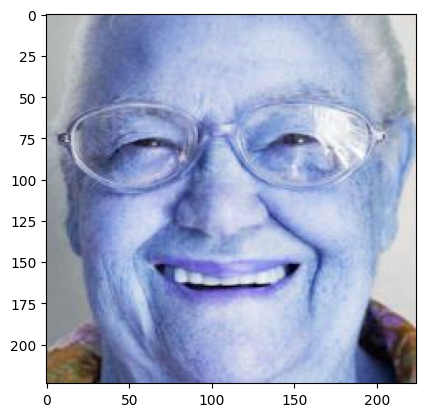

In [ ]:
#display an image of training dataset
img = cv2.imread(train_paths[2])
plt.imshow(img)

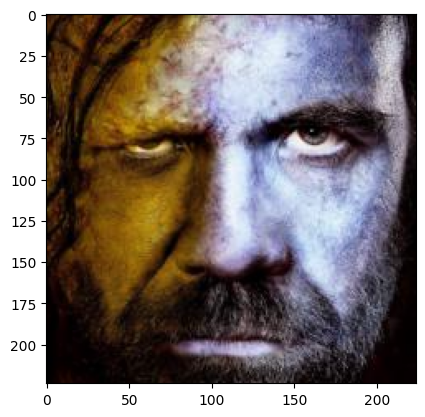

In [ ]:
image = cv2.imread(test_paths[2])
plt.imshow(image)

**Transformations**

In [ ]:
img_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize(size=(299,299)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ]),

    'valid':
    transforms.Compose([
        transforms.Resize(size=(299,299)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ]),

    'test':
    transforms.Compose([
        transforms.Resize(size=(299,299)),
        transforms.ToTensor(),
        #transforms.RandomVerticalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ]),
     }

In [ ]:
class ImageDataSet(Dataset):
    def __init__(self, image_paths,path, transform=False):
        self.image_paths = image_paths
        self.path=path
        self.transform = transform
    def __len__(self):
        return len(self.image_paths)
    @lru_cache()
    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        img = Image.open(image_filepath)
        rgbimg = Image.new("RGB", img.size)
        rgbimg.paste(img)
        t=image_filepath.split('/')[-1]
        t=t.split('.')[0]
        label1=np.load(self.path+t+'_exp.npy')
        label1=label1.astype(np.float32)
        label1=torch.from_numpy(label1)
        label1 = label1.type(torch.LongTensor)

        label2=np.load(self.path+t+'_aro.npy') #arousal
        label2=label2.astype(np.float32)
        label2=torch.from_numpy(label2)
        label2 = label2.type(torch.FloatTensor)

        label3=np.load(self.path+t+'_val.npy') #Ind
        label3=label3.astype(np.float32)
        label3=torch.from_numpy(label3)
        label2 = label2.type(torch.FloatTensor)




        if self.transform is not None:
            rgbimg = self.transform(rgbimg)
        sample = {'image':rgbimg, 'labels': {'exp':label1, 'arousal':label2, 'val':label3}}
   
        return sample

In [ ]:
train_dataset = ImageDataSet(train_paths,'/content/traindata/train_set/annotations/',transform=img_transforms['train'])
valid_dataset = ImageDataSet(valid_paths,'/content/traindata/train_set/annotations/',transform=img_transforms['valid'])
test_dataset = ImageDataSet(test_paths,'/content/testdata/val_set/annotations/',transform=img_transforms['test'])

In [ ]:
def countall(adata):
  count=[0,0,0,0,0,0,0,0]
  for i in adata:
     count[i['labels']['exp']]=count[i['labels']['exp']]+1
  return count
nSamples=countall(train_dataset)
t=min(nSamples)

In [ ]:
normedWeights=torch.tensor([1.6711e-05, 9.3002e-06, 4.9097e-05, 8.8199e-05, 1.9646e-04, 3.2394e-04,5.0421e-05, 3.2906e-04])
normedWeights = normedWeights.to(device)

In [ ]:
loaders_transfer={
    'train':torch.utils.data.DataLoader(train_dataset,batch_size=32,num_workers=4,shuffle=True),
    'valid':torch.utils.data.DataLoader(valid_dataset,batch_size=32,num_workers=4,shuffle=True),
     'test': torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True,num_workers=4)
}

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# **Architecture 1: ResNet 34**

In [ ]:
class MultilabelClassifier(nn.Module):
    def __init__(self, exp, arousal, val):
        super().__init__()

        self.resnet = models.resnet34(pretrained=True)
        for param in self.resnet.parameters():
                       param.requires_grad = False

           
        self.model_wo_fc = nn.Sequential(*(list(self.resnet.children())[:-1]))
        self.exp = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=exp)
        )
        self.arousal = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=arousal)
        )
        self.val = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=val)
        )

    def forward(self, x):
        x = self.model_wo_fc(x)
        x = torch.flatten(x, 1)

        return {
            'exp': self.exp(x),
            'arousal': self.arousal(x),
            'val': self.val(x)
        }

In [ ]:
def criterion(loss,loss_func,outputs,pictures):
  losses = 0
  for i, key in enumerate(outputs):
   if(key=='exp'):
      losses += loss_func(outputs[key],pictures[0])
   if(key=='arousal'):
      t= pictures[1].view(len(pictures[1]),1)
      losses += loss(outputs[key],t)
   if(key=='val'):
      t= pictures[2].view(len(pictures[2]),1)
      losses += loss(outputs[key],t) 
      

  return losses

In [ ]:
def calculate(preds,targets):
  preds2, targets2 = [],[]

  for i in preds:
    for j in range(len(i)):
      preds2.append(i.cpu().numpy()[j])
  for i in targets:
    for j in range(len(i)):
      targets2.append(i.cpu().numpy()[j])

  print(classification_report(targets2, preds2))
  acc = accuracy_score(targets2, preds2)
  return acc

In [ ]:
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy=[]

In [ ]:
def train(n_epochs, loaders, model, optimizer,scheduler, lossl2,loss_func, use_cuda, save_path):
    scaler = GradScaler()
    gradient_accumulations = 16

    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    for epoch in range(1, n_epochs+1):
        # initialize the variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        tpreds =[]
        ttargets = []
        vpreds=[]
        vtargets=[]
  
        ###################
        # training the model #
        ###################
        model.train()

        for batch_idx, (data) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                img = data['image'].cuda()
                exp = data['labels']['exp'].cuda()
                aro = data['labels']['arousal'].cuda()
                val = data['labels']['val'].cuda()
            else:
                img = data['image']
                exp = data['labels']['exp']
                aro = data['labels']['arousal']
                val = data['labels']['val']
          

            with autocast():
                output = model(img)
                pred = output['exp'].max(1, keepdim=True)[1]
                loss = criterion(lossl2,loss_func,output, [exp,aro,val])
            scaler.scale(loss / gradient_accumulations).backward()
            if (batch_idx + 1) % gradient_accumulations == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()


            tpreds.append(pred)
            ttargets.append(exp)
       
           
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (float(loss.data) - train_loss))

        ######################    
        # validating the model #
        ######################
        model.eval()
        
        for batch_idx, (data) in enumerate(loaders['valid']):
            if use_cuda:
                img = data['image'].cuda()
                exp = data['labels']['exp'].cuda()
                aro = data['labels']['arousal'].cuda()
                val = data['labels']['val'].cuda()
            else:
                img = data['image']
                exp = data['labels']['exp']
                aro = data['labels']['arousal']
                val = data['labels']['val']
          
            output = model(img)
            pred = output['exp'].max(1, keepdim=True)[1]
            loss = criterion(lossl2,loss_func,output, [exp,aro,val])
            vpreds.append(pred)
            vtargets.append(exp)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (float(loss.data) - valid_loss))
        
        train_loss = train_loss/len(train_dataset)
        valid_loss = valid_loss/len(valid_dataset)

        training_loss.append(train_loss)
        validation_loss.append(valid_loss)
        
        # printing training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} '.format(
            epoch, 
            train_loss,
            valid_loss
                 ))
        ta=calculate(tpreds,ttargets)
        va=calculate(vpreds,vtargets)
        training_accuracy.append(ta)
        validation_accuracy.append(va)
        scheduler.step()
        
        
        ## saving the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            
            valid_loss_min = valid_loss
           
    # return trained model
    return model

In [ ]:
use_cuda = torch.cuda.is_available()
model_transfer = MultilabelClassifier(8,1,1)
if use_cuda:
    model_transfer = model_transfer.cuda()

# selecting loss function
criterion_transfer = nn.CrossEntropyLoss(normedWeights)
loss_fn = nn.L1Loss()
#using Adam classifier
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.1,momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_transfer, step_size=4, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#n_epochs = 3
n_epochs= 20
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer,exp_lr_scheduler,loss_fn, criterion_transfer, use_cuda, '/content/drive/MyDrive/model5.pt')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1 	Training Loss: 0.000334 	Validation Loss: 0.001290 
              precision    recall  f1-score   support

           0       0.35      0.19      0.24     59919
           1       0.66      0.26      0.38    107412
           2       0.13      0.18      0.15     20343
           3       0.09      0.21      0.13     11316
           4       0.05      0.21      0.08      5104
           5       0.02      0.14      0.03      3024
           6       0.13      0.19      0.15     19975
           7       0.02      0.14      0.03      3027

    accuracy                           0.22    230120
   macro avg       0.18      0.19      0.15    230120
weighted avg       0.43      0.22      0.27    230120

              precision    recall  f1-score   support

           0       0.37      0.60      0.45     14955
           1       0.89      0.32      0.47     27003
           2       0.60      0.01      0.02      5116
           3       0.13      0.50      0.21      2774
           4    

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 2 	Training Loss: 0.000357 	Validation Loss: 0.001604 
              precision    recall  f1-score   support

           0       0.35      0.19      0.25     59919
           1       0.68      0.28      0.39    107412
           2       0.12      0.17      0.14     20343
           3       0.10      0.22      0.14     11316
           4       0.05      0.22      0.08      5104
           5       0.02      0.15      0.03      3024
           6       0.13      0.19      0.15     19975
           7       0.02      0.15      0.03      3027

    accuracy                           0.23    230120
   macro avg       0.18      0.19      0.15    230120
weighted avg       0.44      0.23      0.28    230120



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.33      0.89      0.48     14955
           1       0.89      0.28      0.43     27003
           2       0.20      0.31      0.24      5116
           3       0.00      0.00      0.00      2774
           4       0.00      0.00      0.00      1274
           5       0.00      0.00      0.00       779
           6       0.32      0.02      0.05      4907
           7       0.00      0.00      0.00       723

    accuracy                           0.39     57531
   macro avg       0.22      0.19      0.15     57531
weighted avg       0.55      0.39      0.35     57531



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 3 	Training Loss: 0.000292 	Validation Loss: 0.001041 
              precision    recall  f1-score   support

           0       0.35      0.19      0.25     59919
           1       0.67      0.27      0.39    107412
           2       0.13      0.18      0.15     20343
           3       0.10      0.22      0.14     11316
           4       0.05      0.23      0.09      5104
           5       0.02      0.15      0.04      3024
           6       0.13      0.19      0.16     19975
           7       0.02      0.16      0.03      3027

    accuracy                           0.23    230120
   macro avg       0.18      0.20      0.15    230120
weighted avg       0.44      0.23      0.28    230120



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     14955
           1       0.87      0.01      0.01     27003
           2       0.44      0.01      0.02      5116
           3       0.00      0.00      0.00      2774
           4       0.75      0.00      0.00      1274
           5       0.00      0.00      0.00       779
           6       0.21      0.02      0.03      4907
           7       0.01      1.00      0.03       723

    accuracy                           0.02     57531
   macro avg       0.29      0.13      0.01     57531
weighted avg       0.48      0.02      0.01     57531



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 4 	Training Loss: 0.000572 	Validation Loss: 0.002731 
              precision    recall  f1-score   support

           0       0.35      0.19      0.25     59919
           1       0.67      0.27      0.39    107412
           2       0.13      0.18      0.15     20343
           3       0.10      0.22      0.13     11316
           4       0.05      0.22      0.08      5104
           5       0.02      0.15      0.03      3024
           6       0.13      0.19      0.16     19975
           7       0.02      0.15      0.03      3027

    accuracy                           0.23    230120
   macro avg       0.18      0.20      0.15    230120
weighted avg       0.43      0.23      0.28    230120



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.41      0.33      0.37     14955
           1       0.95      0.11      0.20     27003
           2       0.00      0.00      0.00      5116
           3       0.00      0.00      0.00      2774
           4       0.00      0.00      0.00      1274
           5       0.02      0.58      0.03       779
           6       0.15      0.47      0.23      4907
           7       0.00      0.00      0.00       723

    accuracy                           0.19     57531
   macro avg       0.19      0.19      0.10     57531
weighted avg       0.56      0.19      0.21     57531



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 5 	Training Loss: 0.000056 	Validation Loss: 0.000116 
              precision    recall  f1-score   support

           0       0.44      0.23      0.31     59919
           1       0.77      0.39      0.51    107412
           2       0.18      0.23      0.20     20343
           3       0.13      0.28      0.18     11316
           4       0.07      0.28      0.12      5104
           5       0.02      0.18      0.04      3024
           6       0.17      0.23      0.19     19975
           7       0.02      0.19      0.04      3027

    accuracy                           0.31    230120
   macro avg       0.23      0.25      0.20    230120
weighted avg       0.51      0.31      0.37    230120

              precision    recall  f1-score   support

           0       0.50      0.27      0.35     14955
           1       0.86      0.42      0.57     27003
           2       0.24      0.19      0.21      5116
           3       0.17      0.19      0.18      2774
           4    

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 6 	Training Loss: 0.000050 	Validation Loss: 0.000176 
              precision    recall  f1-score   support

           0       0.46      0.23      0.31     59919
           1       0.76      0.41      0.53    107412
           2       0.19      0.21      0.20     20343
           3       0.14      0.30      0.19     11316
           4       0.08      0.30      0.12      5104
           5       0.03      0.19      0.05      3024
           6       0.19      0.24      0.21     19975
           7       0.02      0.20      0.04      3027

    accuracy                           0.32    230120
   macro avg       0.23      0.26      0.21    230120
weighted avg       0.52      0.32      0.38    230120

              precision    recall  f1-score   support

           0       0.54      0.22      0.31     14955
           1       0.87      0.41      0.56     27003
           2       0.18      0.51      0.27      5116
           3       0.19      0.45      0.27      2774
           4    

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


**Graphs**

In [ ]:
x=list(range(0, len(training_loss)))
# plotting the line 1 points
plt.plot(x,training_accuracy, label = "Training Accuracy")
plt.plot(x,validation_accuracy, label = "Validation Accuracy")
 
# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
# giving a title to my graph
plt.title('Validation Accurcay and Training Accuracy Graph')
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()

NameError: ignored

In [ ]:
x=list(range(0, len(training_loss)))
plt.plot(x,training_loss, label = "Training Loss")
plt.plot(x,validation_loss, label = "Validation Loss")
 
# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
# giving a title to my graph
plt.title('Validation loss and Training Loss Graph')
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()

NameError: ignored

Test

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


tensor([1], device='cuda:0')
tensor(1, device='cuda:0')


tensor([6], device='cuda:0')
tensor(2, device='cuda:0')


tensor([1], device='cuda:0')
tensor(2, device='cuda:0')


tensor([3], device='cuda:0')
tensor(3, device='cuda:0')


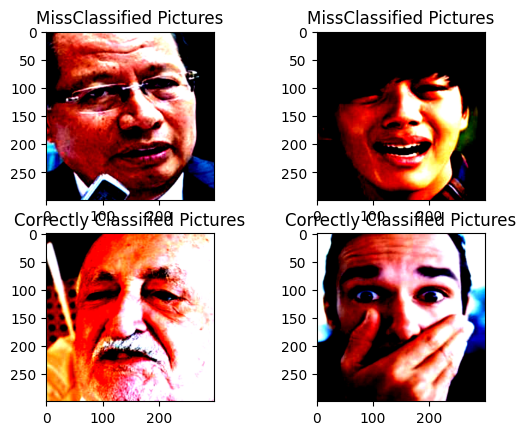

In [ ]:
def test(loaders, model, lossl2,loss_func, use_cuda):
    
    # monitoring test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    preds = []
    targets = []
    apreds=[]
    atargets=[]
    vpreds=[]
    vtargets=[]

    model.eval()
    model.zero_grad()
    noItoShow = 0
    nooItoShow=0
    f, axarr = plt.subplots(2,2)
    for batch_idx, (data) in enumerate(loaders['test']):
           if use_cuda:
                img = data['image'].cuda()
                exp = data['labels']['exp'].cuda()
                aro = data['labels']['arousal'].cuda()
                val = data['labels']['val'].cuda()
           else:
                img = data['image']
                exp = data['labels']['exp']
                aro = data['labels']['arousal']
                val = data['labels']['val']
           output = model(img.detach())
           pred = output['exp'].max(1, keepdim=True)[1]
           arousal=output['arousal']
           valence = output['val']
           preds.append(pred.detach())
           targets.append(exp.detach())
           apreds.append(output['arousal'])
           atargets.append(aro)
           vpreds.append(output['val'])
           vtargets.append(val)
           if noItoShow<2:
            if(pred[0]!=exp.detach()[0]):
              rgbimg = img.detach().cpu().numpy()[0]
             # plt.subplot(1, 2, noItoShow) # row 1, col 2 index 1
              axarr[0,noItoShow].imshow(np.transpose(rgbimg, (1, 2, 0)))
              axarr[0,noItoShow].set_title("MissClassified Pictures")
              print(pred[0])
              print(exp.detach()[0])
              noItoShow = noItoShow+1
           if nooItoShow<2:
            if(pred[0]==exp.detach()[0]):
              rgbimg = img.detach().cpu().numpy()[0]
              axarr[1,nooItoShow].imshow(np.transpose(rgbimg, (1, 2, 0)))
              axarr[1,nooItoShow].set_title("Correctly Classified Pictures")
              print(pred[0])
              print(exp.detach()[0])
              nooItoShow = nooItoShow+1
            

            

           
           #test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        
           #correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
           #total += data.size(0)
    
    return preds, targets, apreds, atargets, vpreds, vtargets
preds, targets, apreds, atargets, vpreds, vtargets = test(loaders_transfer, model_transfer,loss_fn, criterion_transfer, use_cuda)

**Results**

In [ ]:
calculate(preds,targets)

              precision    recall  f1-score   support

           0       0.25      0.02      0.04       500
           1       0.24      0.74      0.37       500
           2       0.00      0.00      0.00       500
           3       0.19      0.78      0.30       500
           4       0.48      0.02      0.04       500
           5       0.00      0.00      0.00       500
           6       0.29      0.16      0.20       500
           7       0.22      0.03      0.06       499

    accuracy                           0.22      3999
   macro avg       0.21      0.22      0.13      3999
weighted avg       0.21      0.22      0.13      3999



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.21855463865966493

In [ ]:
from scipy.stats import pearsonr
def calculateRMSE(ppreds,cpreds):
  criterion = nn.MSELoss()
  preds2, targets2 = [],[]
  loss=0
  for i,k in zip(ppreds,cpreds):
      for j in range(len(i)):
        preds2.append(i.detach().cpu().numpy()[j].item())
        targets2.append(k.detach().cpu().numpy()[j].item())
  loss=torch.sqrt(criterion(torch.Tensor(preds2),torch.Tensor(targets2)))
  print("RMSE: %.3f"% float(loss))
  print("SAGR: %.3f"% float(calculateSAGR(preds2, targets2)))
  corr, _ = np.corrcoef(preds2, targets2)
  print("Correlation:", corr)
  c=concordance_correlation_coefficient(targets2, preds2)
  print("concordance_correlation_coefficient: %.3f"% float(c))

  return loss,corr,c

In [ ]:
def concordance_correlation_coefficient(y_true, y_pred):
    """Concordance correlation coefficient."""
    cor = np.corrcoef(y_true, y_pred)[0][1]
    # Mean
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    # Variance
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    # Standard deviation
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    # Calculate CCC
    numerator = 2 * cor * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred)**2
    return numerator / denominator


In [ ]:
def calculateSAGR(y_true, y_pred):
  t1=np.sign(y_true)
  t2= np.sign(y_pred)
  count=0
  for x,y in zip(t1,t2):
    if(x==y):
      count=count+1
  return count/len(y_true)

In [ ]:
print('Evaluation Measure for Valence')
vr=[vl,vcor,lvcon]=calculateRMSE(vpreds,vtargets)
print('Evaluation Measure for Arousal')
ar=[al,acor,acon]=calculateRMSE(apreds,atargets)

Evaluation Measure for Valence
RMSE: 62.443
SAGR: 0.696
Correlation: [ 1.         -0.01664661]
concordance_correlation_coefficient: -0.000
Evaluation Measure for Arousal
RMSE: 23.367
SAGR: 0.773
Correlation: [1.         0.02464232]
concordance_correlation_coefficient: 0.000


In [ ]:
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):

  #creating a set of all the unique classes using the actual class list
  unique_class = set(actual_class)
  roc_auc_dict = {}
  auc_dict={}
  for per_class in unique_class:
    #creating a list of all the classes except the current class 
    other_class = [x for x in unique_class if x != per_class]

    #marking the current class as 1 and all other classes as 0
    new_actual_class = [0 if x in other_class else 1 for x in actual_class]
    new_pred_class = [0 if x in other_class else 1 for x in pred_class]

    #using the sklearn metrics method to calculate the roc_auc_score
    roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
    roc_auc_dict[per_class] = roc_auc
    pre,recall,_   = precision_recall_curve(new_actual_class, new_pred_class)
    auc_dict[per_class] = auc(recall, pre)

  return roc_auc_dict,auc_dict

In [ ]:
#! /usr/bin/env python
# -*- coding: utf-8
'''
Python implementation of Krippendorff's alpha -- inter-rater reliability
(c)2011-17 Thomas Grill (http://grrrr.org)
Python version >= 2.4 required
'''

from __future__ import print_function
try:
    import numpy as np
except ImportError:
    np = None


def nominal_metric(a, b):
    return a != b


def interval_metric(a, b):
    return (a-b)**2


def ratio_metric(a, b):
    return ((a-b)/(a+b))**2


def krippendorff_alpha(data, metric=interval_metric, force_vecmath=False, convert_items=float, missing_items=None):
    #Calculate Krippendorff's alpha (inter-rater reliability)
    
    # number of coders
    m = len(data)
    
    # set of constants identifying missing values
    if missing_items is None:
        maskitems = []
    else:
        maskitems = list(missing_items)
    if np is not None:
        maskitems.append(np.ma.masked_singleton)
    
    # convert input data to a dict of items
    units = {}
    for d in data:
        try:
            # try if d behaves as a dict
            diter = d.items()
        except AttributeError:
            # sequence assumed for d
            diter = enumerate(d)
            
        for it, g in diter:
            if g not in maskitems:
                try:
                    its = units[it]
                except KeyError:
                    its = []
                    units[it] = its
                its.append(convert_items(g))


    units = dict((it, d) for it, d in units.items() if len(d) > 1)  # units with pairable values
    n = sum(len(pv) for pv in units.values())  # number of pairable values
    
    if n == 0:
        raise ValueError("No items to compare.")
    
    np_metric = (np is not None) and ((metric in (interval_metric, nominal_metric, ratio_metric)) or force_vecmath)
    
    Do = 0.
    for grades in units.values():
        if np_metric:
            gr = np.asarray(grades)
            Du = sum(np.sum(metric(gr, gri)) for gri in gr)
        else:
            Du = sum(metric(gi, gj) for gi in grades for gj in grades)
        Do += Du/float(len(grades)-1)
    Do /= float(n)

    if Do == 0:
        return 1.

    De = 0.
    for g1 in units.values():
        if np_metric:
            d1 = np.asarray(g1)
            for g2 in units.values():
                De += sum(np.sum(metric(d1, gj)) for gj in g2)
        else:
            for g2 in units.values():
                De += sum(metric(gi, gj) for gi in g1 for gj in g2)
    De /= float(n*(n-1))

    return 1.-Do/De if (Do and De) else 1.

In [ ]:
from sklearn.metrics import cohen_kappa_score,roc_curve,roc_auc_score,auc,precision_recall_curve
#import simpledorff

def calc(preds,targets):
  preds2, targets2 = [],[]

  for i in preds:
    for j in range(len(i)):
      preds2.append(i.cpu().numpy()[j])
  for i in targets:
    for j in range(len(i)):
      targets2.append(i.cpu().numpy()[j])
  print("Cohens Kappa Score: %.3f"% float(cohen_kappa_score(targets2,preds2)))
  weighted_roc_auc,aoc_recallauc = roc_auc_score_multiclass(targets2, preds2)
  print("Area Under Curve: %.3f" % float(sum(weighted_roc_auc.values())/8))
  print("AUC – Precision Recall: %.3f" % float(sum(aoc_recallauc.values())/8))
  lis = [targets2,preds2]
  print("nominal metric: %.3f" % krippendorff_alpha(lis, nominal_metric, missing_items=None))


calc(preds,targets)

Cohens Kappa Score: 0.107
Area Under Curve: 0.553
AUC – Precision Recall: 0.387
nominal metric: 0.026


# **Architecture 2: Xception41**

In [ ]:
def criterion(loss,loss_func,outputs,pictures):
  losses = 0
  for i, key in enumerate(outputs):
   if(key=='exp'):
      losses += loss_func(outputs[key],pictures[0])
   if(key=='arousal'):
      t= pictures[1].view(len(pictures[1]),1)
      losses += loss(outputs[key],t)
   if(key=='val'):
      t= pictures[2].view(len(pictures[2]),1)
      losses += loss(outputs[key],t) 
      

  return losses

In [ ]:
def calculate(preds,targets):
  preds2, targets2 = [],[]

  for i in preds:
    for j in range(len(i)):
      preds2.append(i.cpu().numpy()[j])
  for i in targets:
    for j in range(len(i)):
      targets2.append(i.cpu().numpy()[j])

  print(classification_report(targets2, preds2))
  acc = accuracy_score(targets2, preds2)
  return acc

In [ ]:
class MultilabelClassifier(nn.Module):
    def __init__(self, exp, arousal, val):
        super().__init__()
        self.resnet = timm.create_model('xception41', pretrained=True,num_classes=0)

        cnr=0
        
        for param in self.resnet.parameters():
                       cnr=cnr+1
                       if(cnr<251):
                          param.requires_grad = False        
       
        self.exp = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(2048, out_features=exp)
        )
        self.arousal = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(2048, out_features=arousal)
        )
        self.val = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(2048, out_features=val)
        )
    def forward(self, x):
        x = self.resnet(x)
        

        return {
            'exp': self.exp(x),
            'arousal': self.arousal(x),
            'val': self.val(x)
        }

In [ ]:
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy=[]

In [ ]:
use_cuda = torch.cuda.is_available()
model_transfer = MultilabelClassifier(8,1,1)
if use_cuda:
    model_transfer = model_transfer.cuda()

# selecting loss function
criterion_transfer = nn.CrossEntropyLoss(normedWeights)
loss_fn = nn.L1Loss()
#using Adam classifier
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.1,momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_transfer, step_size=4, gamma=0.1)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_xception_41-e6439c97.pth" to /root/.cache/torch/hub/checkpoints/tf_xception_41-e6439c97.pth


In [ ]:
n_epochs= 3
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer,exp_lr_scheduler,loss_fn, criterion_transfer, use_cuda, '/content/drive/MyDrive/model5.pt')

**Graphs**

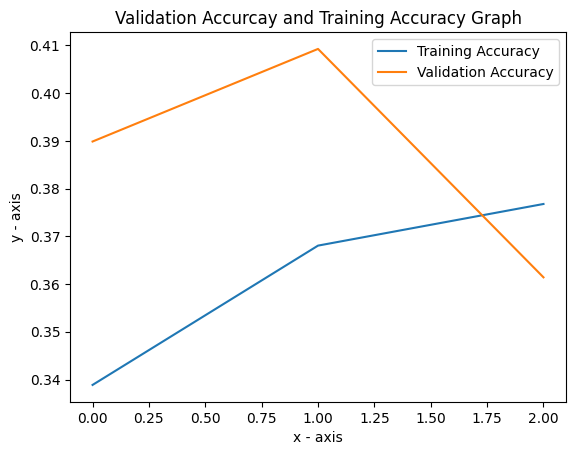

In [ ]:
x=list(range(0, len(training_loss)))
# plotting the line 1 points
plt.plot(x,training_accuracy, label = "Training Accuracy")
plt.plot(x,validation_accuracy, label = "Validation Accuracy")
 
# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
# giving a title to my graph
plt.title('Validation Accurcay and Training Accuracy Graph')
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()

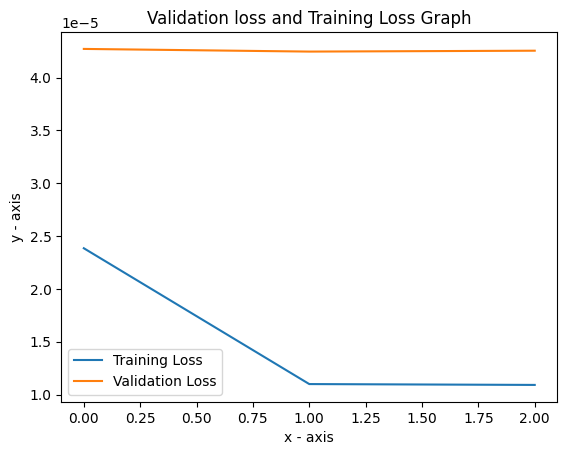

In [ ]:
x=list(range(0, len(training_loss)))
plt.plot(x,training_loss, label = "Training Loss")
plt.plot(x,validation_loss, label = "Validation Loss")
 
# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
# giving a title to my graph
plt.title('Validation loss and Training Loss Graph')
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()

Test

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


tensor([7], device='cuda:0')
tensor(2, device='cuda:0')


tensor([2], device='cuda:0')
tensor(4, device='cuda:0')


tensor([5], device='cuda:0')
tensor(5, device='cuda:0')


tensor([7], device='cuda:0')
tensor(7, device='cuda:0')


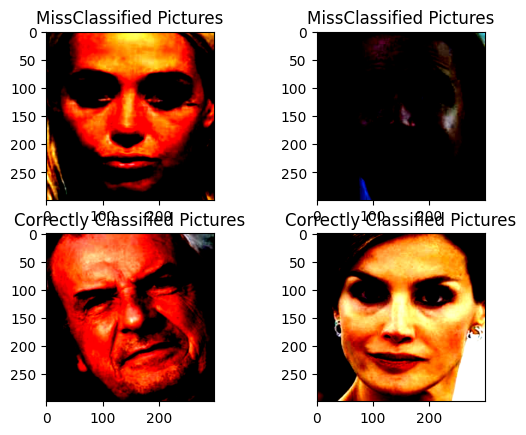

In [ ]:
def test(loaders, model, lossl2,loss_func, use_cuda):
    
    # monitoring test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    preds = []
    targets = []
    apreds=[]
    atargets=[]
    vpreds=[]
    vtargets=[]

    model.eval()
    model.zero_grad()
    noItoShow = 0
    nooItoShow=0
    f, axarr = plt.subplots(2,2)
    for batch_idx, (data) in enumerate(loaders['test']):
           if use_cuda:
                img = data['image'].cuda()
                exp = data['labels']['exp'].cuda()
                aro = data['labels']['arousal'].cuda()
                val = data['labels']['val'].cuda()
           else:
                img = data['image']
                exp = data['labels']['exp']
                aro = data['labels']['arousal']
                val = data['labels']['val']
           output = model(img.detach())
           pred = output['exp'].max(1, keepdim=True)[1]
           arousal=output['arousal']
           valence = output['val']
           preds.append(pred.detach())
           targets.append(exp.detach())
           apreds.append(output['arousal'])
           atargets.append(aro)
           vpreds.append(output['val'])
           vtargets.append(val)
           if noItoShow<2:
            if(pred[0]!=exp.detach()[0]):
              rgbimg = img.detach().cpu().numpy()[0]
             # plt.subplot(1, 2, noItoShow) # row 1, col 2 index 1
              axarr[0,noItoShow].imshow(np.transpose(rgbimg, (1, 2, 0)))
              axarr[0,noItoShow].set_title("MissClassified Pictures")
              print(pred[0])
              print(exp.detach()[0])
              noItoShow = noItoShow+1
           if nooItoShow<2:
            if(pred[0]==exp.detach()[0]):
              rgbimg = img.detach().cpu().numpy()[0]
              axarr[1,nooItoShow].imshow(np.transpose(rgbimg, (1, 2, 0)))
              axarr[1,nooItoShow].set_title("Correctly Classified Pictures")
              print(pred[0])
              print(exp.detach()[0])
              nooItoShow = nooItoShow+1
            

            

           
           #test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        
           #correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
           #total += data.size(0)
    
    return preds, targets, apreds, atargets, vpreds, vtargets
preds, targets, apreds, atargets, vpreds, vtargets = test(loaders_transfer, model_transfer,loss_fn, criterion_transfer, use_cuda)

**Results**

In [ ]:
calculate(preds,targets)

              precision    recall  f1-score   support

           0       0.27      0.23      0.25       500
           1       0.41      0.48      0.44       500
           2       0.21      0.35      0.26       500
           3       0.34      0.25      0.29       500
           4       0.42      0.35      0.38       500
           5       0.27      0.12      0.17       500
           6       0.29      0.30      0.29       500
           7       0.26      0.31      0.28       499

    accuracy                           0.30      3999
   macro avg       0.31      0.30      0.30      3999
weighted avg       0.31      0.30      0.30      3999



0.29982495623905975

In [ ]:
print('Evaluation Measure for Valence')
vr=[vl,vcor,lvcon]=calculateRMSE(vpreds,vtargets)
print('Evaluation Measure for Arousal')
ar=[al,acor,acon]=calculateRMSE(apreds,atargets)

Evaluation Measure for Valence
RMSE: 0.630
SAGR: 0.400
Correlation: [1.         0.20484192]
concordance_correlation_coefficient: 0.107
Evaluation Measure for Arousal
RMSE: 0.425
SAGR: 0.771
Correlation: [1.         0.16730791]
concordance_correlation_coefficient: 0.052


In [ ]:
from sklearn.metrics import cohen_kappa_score,roc_curve,roc_auc_score,auc,precision_recall_curve
#import simpledorff

def calc(preds,targets):
  preds2, targets2 = [],[]

  for i in preds:
    for j in range(len(i)):
      preds2.append(i.cpu().numpy()[j])
  for i in targets:
    for j in range(len(i)):
      targets2.append(i.cpu().numpy()[j])
  print("Cohens Kappa Score: %.3f"% float(cohen_kappa_score(targets2,preds2)))
  weighted_roc_auc,aoc_recallauc = roc_auc_score_multiclass(targets2, preds2)
  print("Area Under Curve: %.3f" % float(sum(weighted_roc_auc.values())/8))
  print("AUC – Precision Recall: %.3f" % float(sum(aoc_recallauc.values())/8))
  lis = [targets2,preds2]
  print("nominal metric: %.3f" % krippendorff_alpha(lis, nominal_metric, missing_items=None))


calc(preds,targets)

Cohens Kappa Score: 0.200
Area Under Curve: 0.600
AUC – Precision Recall: 0.347
nominal metric: 0.197
